In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop, SGD

In [17]:
df = pd.read_csv("./processed_adhdata.csv")
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD->1, Control->0

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape((window_count, frequency_count, numeric_df.shape[1]))

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

# Standardize across the entire dataset
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat  = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(X_train.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

Train shape: (6623, 77, 19, 1)


In [18]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  
        # -> (N, 1, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

In [23]:
import torch
import torch.nn as nn
import numpy as np

class EEGCNNLSTM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1   = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool    = nn.AvgPool2d(2)
        self.conv2   = nn.Conv2d(32, 64, kernel_size=2)
        self.dropout = nn.Dropout(0.5)

        # Compute flatten size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, X_train.shape[1], X_train.shape[2])
            out = self._forward_features(dummy)   # [B, C, H, W]
            b, c, h, w = out.shape
            self.seq_len = h                      # sequence length (rows)
            self.cnn_feat_dim = c * w             # CNN features per timestep

        # Dense layer BEFORE LSTM
        self.dense_before_lstm = nn.Linear(self.cnn_feat_dim, 64)

        # Two stacked LSTM layers
        self.lstm = nn.LSTM(
            input_size=64,      # dense output size is LSTM input
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        # Final classification head
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, num_classes)

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        return x

    def forward(self, x):
        # 1️⃣ CNN feature extraction
        x = self._forward_features(x)             # [B, C, H, W]

        # 2️⃣ Prepare sequence for LSTM
        x = x.permute(0, 2, 1, 3)                 # [B, H, C, W]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, H, C*W]

        # 3️⃣ Dense layer for each timestep
        x = F.relu(self.dense_before_lstm(x))     # [B, H, dense_size]

        # 4️⃣ Two-layer LSTM
        lstm_out, _ = self.lstm(x)                # [B, H, hidden_size]

        # 5️⃣ Use last time step (or mean/attention if preferred)
        x = lstm_out[:, -1, :]                    # [B, hidden_size]

        # 6️⃣ Fully connected head
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def fit(self, train_loader, test_loader, epochs, criterion, optimizer, device):
        best_val_loss = float('inf')
        patience = 100
        no_improve = 0

        train_losses, train_accs = [], []
        val_losses, val_accs     = [], []

        for epoch in range(epochs):
            # --- Train ---
            self.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                out = self(xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * xb.size(0)
                train_correct += (out.argmax(1) == yb).sum().item()
                train_total += yb.size(0)

            train_loss /= train_total
            train_acc  = train_correct / train_total
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # --- Validate ---
            self.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = self(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
                    val_correct += (out.argmax(1) == yb).sum().item()
                    val_total += yb.size(0)

            val_loss /= val_total
            val_acc  = val_correct / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_loss - train_loss > 0.2:
                print("Overfitting detected.")
                break
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = self.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered.")
                    break

        self.load_state_dict(best_state)
        return {
            "train_accs": np.array(train_accs),
            "train_losses": np.array(train_losses),
            "val_accs":   np.array(val_accs),
            "val_losses": np.array(val_losses)
        }

In [27]:
class CNNLSTM(nn.Module):
    def __init__(self, freq_bins, input_feats, lstm_hidden=64, num_classes=2):
        super().__init__()
        # CNN operates on (batch, 1, freq_bins, input_feats)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), padding=1),  # preserve dims
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2)),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2))
        )
        # Compute flattened feature size after conv/pool
        dummy = torch.zeros(1,1,freq_bins,input_feats)
        with torch.no_grad():
            cnn_out = self.cnn(dummy)
        self.cnn_feat_size = cnn_out.numel()

        # LSTM expects (batch, seq_len, input_size)
        self.lstm = nn.LSTM(
            input_size=self.cnn_feat_size,
            hidden_size=lstm_hidden,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, features)
        # Treat each timestep as a "single-channel image"
        batch, seq_len, feats = x.shape
        x = x.unsqueeze(2)                     # (B, seq_len, 1, features)
        x = x.permute(0,2,1,3)                  # (B, 1, seq_len, features)
        # CNN over (freq_bins, features)
        x = self.cnn(x)                         # (B, C, f', f'')
        x = x.view(batch, -1)                   # collapse all spatial dims
        # Repeat same CNN output for each sequence step (single global window)
        x = x.unsqueeze(1)                      # (B, 1, cnn_feat_size)
        out, (h,c) = self.lstm(x)               # process as 1-step sequence
        out = self.dropout(h[-1])
        return self.fc(out)

freq_bins   = X_train.shape[1]   # timesteps
input_feats = X_train.shape[2]   # electrode features
model = CNNLSTM(freq_bins, input_feats).to('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------
# Training Loop
# ----------------------
device = next(model.parameters()).device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 100
train_losses,val_losses,train_accs,val_accs = [],[],[],[]

for epoch in range(num_epochs):
    model.train()
    run_loss, correct, total = 0.0,0,0
    for Xb,yb in train_loader:
        Xb,yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out,yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item()*Xb.size(0)
        preds = out.argmax(1)
        correct += (preds==yb).sum().item()
        total += yb.size(0)
    train_losses.append(run_loss/total)
    train_accs.append(correct/total)

    model.eval()
    run_loss, correct, total = 0.0,0,0
    with torch.no_grad():
        for Xb,yb in test_loader:
            Xb,yb = Xb.to(device), yb.to(device)
            out = model(Xb)
            loss = criterion(out,yb)
            run_loss += loss.item()*Xb.size(0)
            preds = out.argmax(1)
            correct += (preds==yb).sum().item()
            total += yb.size(0)
    val_losses.append(run_loss/total)
    val_accs.append(correct/total)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss:{train_losses[-1]:.4f} Train Acc:{train_accs[-1]:.4f} "
          f"Val Loss:{val_losses[-1]:.4f} Val Acc:{val_accs[-1]:.4f}")

# ----------------------
# Plot curves
# ----------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(train_accs,label="Train"); plt.plot(val_accs,label="Val")
plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_losses,label="Train"); plt.plot(val_losses,label="Val")
plt.title("Loss"); plt.legend()
plt.tight_layout(); plt.show()


ValueError: too many values to unpack (expected 3)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 2

model = EEGCNNLSTM(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

history = model.fit(train_loader, test_loader, epochs=300, criterion=criterion,
                    optimizer=optimizer, device=device)

Epoch 001 | Train Loss: 0.6871 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 002 | Train Loss: 0.6863 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 003 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 004 | Train Loss: 0.6867 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 005 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6864 Acc: 0.5586
Epoch 006 | Train Loss: 0.6865 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 007 | Train Loss: 0.6870 Acc: 0.5582 | Val Loss: 0.6864 Acc: 0.5586
Epoch 008 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 009 | Train Loss: 0.6864 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 010 | Train Loss: 0.6865 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 011 | Train Loss: 0.6865 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 012 | Train Loss: 0.6864 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 013 | Train Loss: 0.6866 Acc: 0.5582 | Val Loss: 0.6863 Acc: 0.5586
Epoch 014 | Train Loss: 0.6865 Acc: 0.

In [21]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.5585748792270532
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       925
           1       0.00      0.00      0.00       731

    accuracy                           0.56      1656
   macro avg       0.28      0.50      0.36      1656
weighted avg       0.31      0.56      0.40      1656

[[925   0]
 [731   0]]


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


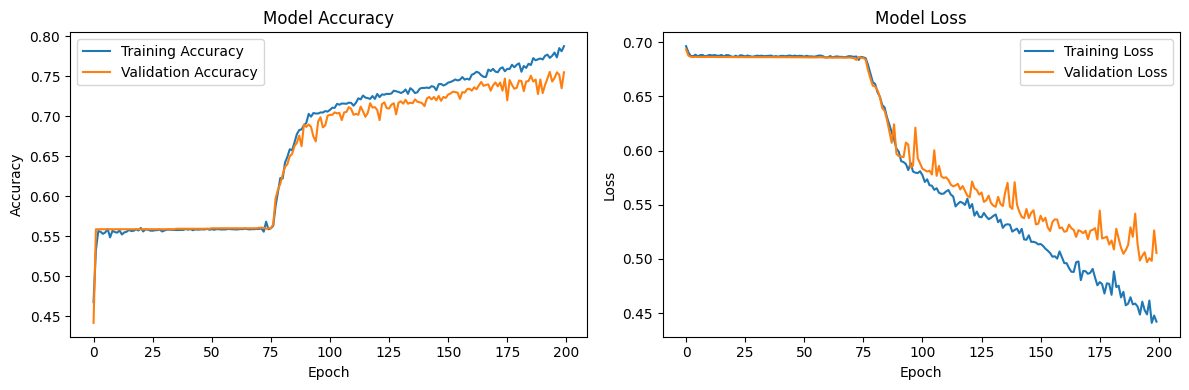

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()